In [28]:
import os
import pandas as pd
import numpy as np
import json
import joblib
import pickle
import requests
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


### Reading Data

In [3]:
df = pd.read_csv(r'/Users/joaopinto/projects/Capstone-LDSA/data/two-years-recid.csv')
df.head()

,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


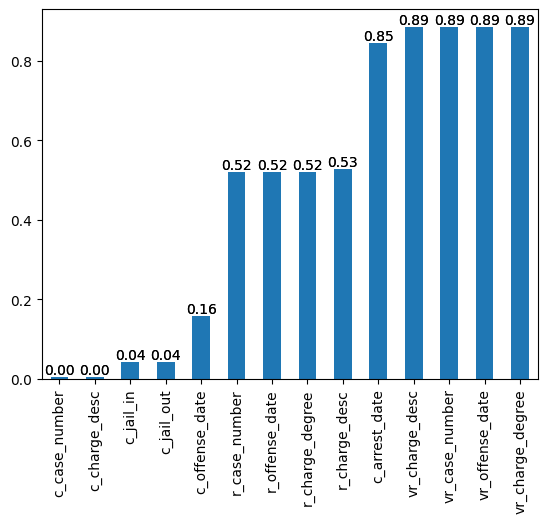

In [4]:
nas=df.isna().sum().apply(lambda x: x/len(df)).sort_values()
nas_plot= nas[nas!=0]
nas_plot.plot(kind='bar')
# Plot the bar chart
ax = nas_plot.plot(kind='bar', label=True)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Display the plot
plt.show()

### Feature Engineering

#### Preprocessing

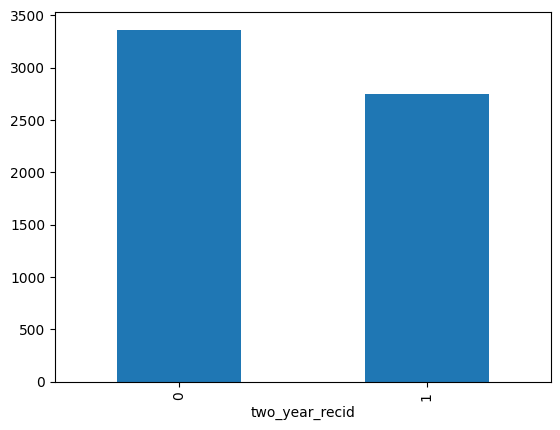

In [5]:
target = 'two_year_recid'
y = df[target]
y.value_counts().plot(kind='bar');

In [13]:
X = df[[col for col in df.columns if col != target]]

drop_cols = [
    'id',
    'name',
    'dob',
    'race',
    'score_text',
    #'is_recid',
    'c_jail_in',
    'c_jail_out',
    'c_case_number',
    'compas_screening_date',
    'c_offense_date',
    'c_arrest_date',
    'r_case_number',
    'r_offense_date',
    'vr_case_number',
    'vr_offense_date',
    'vr_charge_degree',
    'vr_charge_desc',
    
]

X = X.drop(columns=drop_cols)
X.head()


,sex,age,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,type_of_assessment,decile_score,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_charge_degree,r_charge_desc,is_violent_recid
0,Male,62,F,False Imprisonment,0,0,0,0,Risk of Recidivism,1,Risk of Violence,1,Low,0,NaN,NaN,0
1,Male,28,M,Battery,0,0,0,1,Risk of Recidivism,3,Risk of Violence,3,Low,0,NaN,NaN,0
2,Male,57,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,Risk of Recidivism,4,Risk of Violence,2,Low,1,(M2),Driving License Suspended,0
3,Male,19,F,arrest case no charge,0,1,0,1,Risk of Recidivism,10,Risk of Violence,10,High,1,(M1),Possess Cannabis/20 Grams Or Less,0
4,Female,37,M,Battery,0,0,0,0,Risk of Recidivism,1,Risk of Violence,1,Low,0,NaN,NaN,0


#### Custom Transformers

In [8]:
class DateTimeConverter(BaseEstimator, TransformerMixin):
    """
    A custom transformer to convert specified columns of a DataFrame to lowercase.
    """
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Nothing to do here as there's no fitting process for lowering case
        return self    
    
    def transform(self, X):
        """
        Transform string columns into datetime columns to the DataFrame.
        
        Parameters:
        X (pd.DataFrame): The DataFrame to modify.

        Returns:
        pd.DataFrame: The DataFrame with lowercase columns.
        """
        X = X.copy()  # Create a copy of the input DataFrame to avoid changing the original data
        for column in self.columns:
            if column in X.columns:
                X[column] = X[column].astype(str)
                X[column] = pd.to_datetime(X[column])
            else:
                print(f"Warning: '{column}' does not exist in the DataFrame.")
        return X

In [9]:
class LowercaseTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to convert specified columns of a DataFrame to lowercase.
    """
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Nothing to do here as there's no fitting process for lowering case
        return self    
    
    def transform(self, X):
        """
        Apply the lowercase transformation to the DataFrame.
        
        Parameters:
        X (pd.DataFrame): The DataFrame to modify.

        Returns:
        pd.DataFrame: The DataFrame with lowercase columns.
        """
        X = X.copy()  # Create a copy of the input DataFrame to avoid changing the original data
        for column in self.columns:
            if column in X.columns:
                X[column] = X[column].astype(str)
                X[column] = X[column].str.lower()
            else:
                print(f"Warning: '{column}' does not exist in the DataFrame.")
        return X

### Pipeline

In [31]:
# Define preprocessing steps
numeric_features = [
    'age',
    'decile_score'
    ]



numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        #('lowercase', LowercaseTransformer(categorical_features)),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(C=0.1,penalty='l2', random_state=42,))

In [27]:
# Perform Cross Validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')
print(f'Accuracy: {round(accuracy, 4)}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'F1 Score: {round(f1, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Recall: {round(recall, 4)}')

Cross-Validation Accuracy Scores: [0.9787408  0.9681112  0.97383483 0.95993459 0.97299509]
Mean Cross-Validation Accuracy: 0.970723302549471
Accuracy: 0.9697
Confusion Matrix:
[[625  37]
 [  0 561]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       662
           1       0.94      1.00      0.97       561

    accuracy                           0.97      1223
   macro avg       0.97      0.97      0.97      1223
weighted avg       0.97      0.97      0.97      1223

F1 Score: 0.9698
Precision: 0.9716
Recall: 0.9697


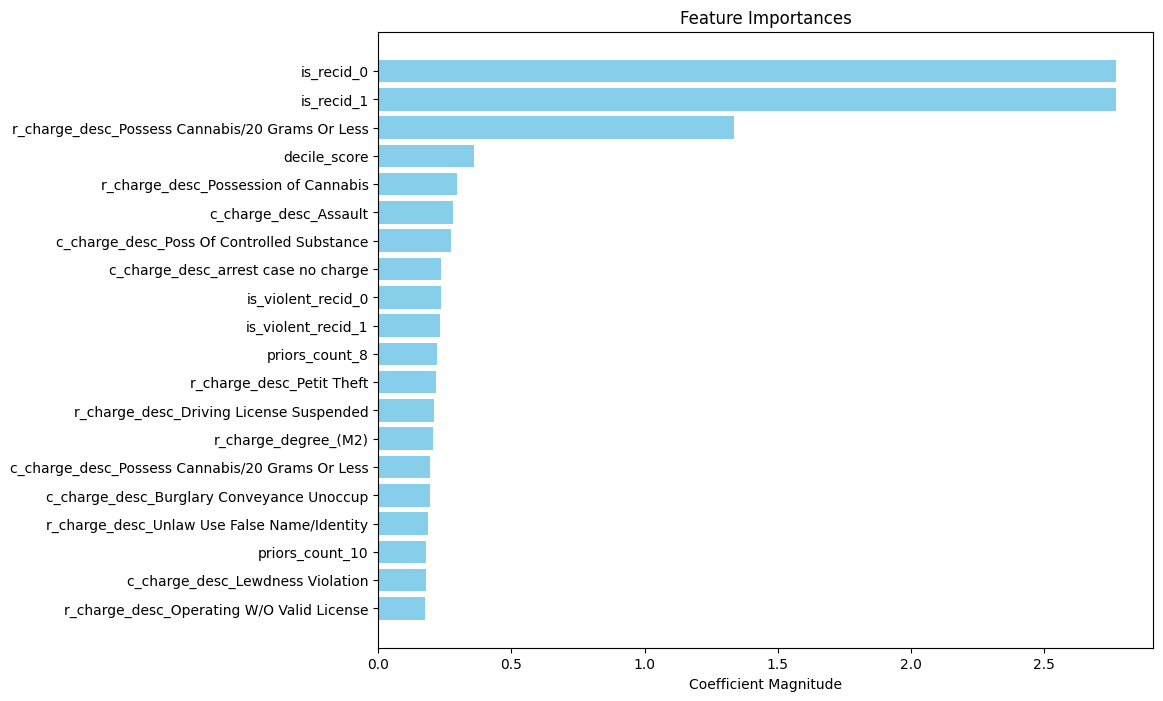

In [21]:
# Extract feature names after one-hot encoding
numeric_features = np.array(numeric_features)
categorical_transformer = pipeline.named_steps['columntransformer'].named_transformers_['cat']
categorical_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, categorical_feature_names])

# Get the coefficients from the logistic regression model
log_reg = pipeline.named_steps['logisticregression']
coefficients = log_reg.coef_[0]

# Create a dataframe for feature names and their corresponding coefficients
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the dataframe by the absolute value of the coefficients
feature_importances['Importance'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Model Choice

In [24]:
raise ValueError
# Define a dictionary of models with their respective parameter grids for hyperparameter tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    #'Random Forest': {
    #    'model': RandomForestClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [100, 200, 300],
    #        'classifier__max_depth': [None, 5, 10, 20],
    #        'classifier__min_samples_split': [2, 5, 10],
    #        'classifier__min_samples_leaf': [1, 2, 4],
    #        'classifier__bootstrap': [True, False]
    #    }
    #},
    #'Support Vector Machine': {
    #    'model': SVC(),
    #    'params': {
    #        'classifier__C': [0.1, 1.0, 10.0],
    #        'classifier__kernel': ['linear', 'rbf']
    #    }
    #},
    #'AdaBoost': {
    #    'model': AdaBoostClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0]
    #    }
    #},
    #'Gradient Boosting': {
    #    'model': GradientBoostingClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0],
    #        'classifier__max_depth': [3, 5, 7]
    #    }
    #},
    #'K-Nearest Neighbors': {
    #    'model': KNeighborsClassifier(),
    #    'params': {
    #        'classifier__n_neighbors': [3, 5, 7],
    #        'classifier__weights': ['uniform', 'distance']
    #    }
    #},
    #'Multi-layer Perceptron': {
    #    'model': MLPClassifier(),
    #    'params': {
    #        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    #        'classifier__activation': ['logistic', 'relu'],
    #        'classifier__alpha': [0.0001, 0.001, 0.01]
    #    }
    #}
}

# Test each model using grid search for hyperparameter tuning
for name, model_info in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_info['model'])])
    
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"F1 Score: {round(grid_search.best_score_,2)}")


ValueError: 